In [1]:
from collections.abc import Iterable
import os

from adjustText import adjust_text
import colorsys
from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import latex
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import pickle
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import pywt
import scipy.io as sio
import scipy
from scipy.stats import multivariate_normal, spearmanr
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import skimage.io as skio
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from tifffile import TiffFile
import tifffile

from networkx import kamada_kawai_layout

from atlas import loadmat, NPAtlas, NWBAtlas
from process_file import get_nwb_neurons, get_dataset_neurons, get_dataset_online, combine_datasets, get_pairings, get_color_discrim, get_neur_nums
from stats import get_summary_stats, analyze_pairs, get_accuracy
from visualization import plot_num_heatmap, plot_std_heatmap, plot_summary_stats, plot_color_discrim, plot_accuracies, plot_visualizations_atlas, plot_visualizations_data, plot_atlas2d_super
from utils import covar_to_coord, convert_coordinates, maha_dist, run_linear_assignment

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
#from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries

In [ ]:
#Optional import if you want to open figures in a separate window, add %matplotlib qt to top of any code box if you want figures to open in a separate window 
import PyQt6.QtCore
os.environ["QT_API"] = "pyqt6"

# Figure 5: Benchmarking atlas performances

Figure 5 demonstrates the results of benchmarking three different atlases on the full corpus of data. 

In [2]:
atlas = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_match_full_nosplit.pkl') # Load atlas
atlas_df = atlas.get_df()
atlas_neurons = np.asarray(atlas_df['ID'])
atlas.df = atlas.df.drop(atlas.df[atlas.df['ID']=='IL1V'].index)

In [4]:
'''
Can either load datasets using get_dataset_neurons with path to a folder of NWB files or using get_dataset_online to stream in data from an online dandiset.
Note that streaming from online will take much longer to load here but bypasses the need to have any files stored on your local hard drive.
'''

data_path = 'insert path to folder containing NWB files to load or stream from online'
#dataset = get_dataset_neurons(data_path, atlas_neurons)

EY_dataset = get_dataset_online('000541', atlas_neurons) #dandi_id = 000541
SK1_dataset = get_dataset_online('000565', atlas_neurons) #dandi_id = 000565
NP_dataset = get_dataset_online('000715', atlas_neurons) #dandi_id = 000715
SK2_dataset = get_dataset_online('000472', atlas_neurons) #dandi_id = 000472
HL_dataset = get_dataset_online('000714', atlas_neurons) #dandi_id = 000714
KK_dataset = get_dataset_online('000692', atlas_neurons) #dandi_id = 000692
SF_dataset = get_dataset_online('000776', atlas_neurons) #dandi_id = 000776

20190924_02
20190924_01
20190925_04
20190924_03
20190925_01
20190928_03
20190928_05
20190928_01
20190928_08
20190928_11
20190929_02
20190928_13
20190929_05
20190929_03
20190928_07
20190929_07
20191104_10
20191030_03
20191104_08
20190929_06
20191030_07
20221106-21-00-09
20221215-20-02-49
20221106-21-47-31
20221028-18-48-00
20221106-21-23-19
20230322-21-41-10
20230322-22-43-03
20230412-20-15-17
20230506-12-56-00
20230506-14-24-57
20230322-18-57-04
20230510-13-25-46
20230510-15-49-47
20230904-14-30-52
20230904-15-09-05
20230904-15-59-40
20230909-16-48-09
20230510-12-53-34
20230322-20-16-50
20230506-15-01-45
20230506-15-33-51
56_YAaDV
38_YAaDV
11_YAaLR
55_YAaDV
20_YAaLR
62_YAaLR
70_YAaLR
7_YAaLR
64_YAaDV
76_YAaDV
2022-02-11-w03-NP1
2021-12-03-w00-NP1
2022-02-12-w00-NP1
2022-02-12-w01-NP1
2022-01-22-w04-NP1
2022-02-22-w04-NP1
2022-04-01-w00-NP1
2022-03-05-w00-NP1
2022-04-26-w01-NP1
2022-04-26-w00-NP1
5
4
2
1
7
6
8
3
9
20230918-9-54-0
20230928-14-27-0
20230928-11-14-0
20230918-13-21-0
202309

In [5]:
def maha_dist(data, mu, sigma):

    data_mu = data-mu
    inv_sigma = np.linalg.inv(sigma)
    left_data = np.dot(data_mu, inv_sigma)
    mahal = np.dot(left_data, data_mu.T)

    return np.sqrt(mahal)

def run_linear_assignment(df_data, atlas):
    #df_data should have columns 'X', 'Y', 'Z', 'R', 'G', 'B', 'ID' 

    df_assigns = df_data.copy()

    mu = atlas.mu
    sigma = atlas.sigma
    neurons = np.asarray(atlas.neurons)

    xyzrgb = np.asarray(df_data[['X','Y','Z','R','G','B']])
    gt_labels = np.asarray(df_data['ID'])

    assigns = np.empty((xyzrgb.shape[0],5),np.dtype('U100'))
    assign_cost = np.zeros((xyzrgb.shape[0], 3, 5)) #total, position, color in second dimension, top 5 ranks in third 

    cost_mat = np.zeros((xyzrgb.shape[0], mu.shape[0]))
    cost_pos = np.zeros((xyzrgb.shape[0], mu.shape[0]))
    cost_col = np.zeros((xyzrgb.shape[0], mu.shape[0]))

    for i in range(xyzrgb.shape[0]):
        for j in range(mu.shape[0]):
            cost = maha_dist(xyzrgb[i,:], mu[j,:], sigma[:,:,j])
            cost_pos[i,j] = maha_dist(xyzrgb[i,:3], mu[j,:3], sigma[:3,:3,j])
            cost_col[i,j] = maha_dist(xyzrgb[i,3:], mu[j,3:], sigma[3:,3:,j])

            cost_mat[i,j] = cost

    for k in range(5):

        row_inds, col_inds = linear_sum_assignment(cost_mat)

        assigns[row_inds,k] = np.asarray(neurons[col_inds])

        assign_cost[row_inds, 0, k] = cost_mat[row_inds, col_inds]
        assign_cost[row_inds, 1, k] = cost_pos[row_inds, col_inds]
        assign_cost[row_inds, 2, k] = cost_col[row_inds, col_inds]

        cost_mat[row_inds, col_inds] = np.inf

    df_assigns['assign_1'] = assigns[:,0]
    df_assigns['assign_2'] = assigns[:,1]
    df_assigns['assign_3'] = assigns[:,2]
    df_assigns['assign_4'] = assigns[:,3]
    df_assigns['assign_5'] = assigns[:,4]

    return df_assigns, assign_cost

In [6]:
def get_accuracies(folder, atlas):
    acc_df = pd.DataFrame(columns=['Total_neurons','Percent_IDd', 'Percent_top1', 'Percent_top2', 'Percent_top3', 'Percent_top4', 'Percent_top5', 'Filename'])
    for file in os.listdir(folder):
        if not file[-4:] == '.csv':
            continue

        df_data = pd.read_csv(folder + '/'+file)
        df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

        df, costs = run_linear_assignment(df_data, atlas)

        IDd = df[~df['ID'].isnull()]

        per_ID = len(IDd.index)/len(df.index)

        total_neurons = len(df.index)

        corr1 = df.loc[df['ID']==df['assign_1']]
        corr2 = df.loc[df['ID']==df['assign_2']]
        corr3 = df.loc[df['ID']==df['assign_3']]
        corr4 = df.loc[df['ID']==df['assign_4']]
        corr5 = df.loc[df['ID']==df['assign_5']]
            
        corr_cum_2 = pd.concat([corr1,corr2]).drop_duplicates().reset_index(drop=True)
        corr_cum_3 = pd.concat([corr_cum_2,corr3]).drop_duplicates().reset_index(drop=True)
        corr_cum_4 = pd.concat([corr_cum_3,corr4]).drop_duplicates().reset_index(drop=True)
        corr_cum_5 = pd.concat([corr_cum_4, corr5]).drop_duplicates().reset_index(drop=True)

        per_corr_1 = len(corr1.index)/len(IDd.index)
        per_corr_2 = len(corr_cum_2.index)/len(IDd.index)
        per_corr_3 = len(corr_cum_3.index)/len(IDd.index)
        per_corr_4 = len(corr_cum_4.index)/len(IDd.index)
        per_corr_5 = len(corr_cum_5.index)/len(IDd.index)

        acc_df.loc[len(acc_df.index)] = [total_neurons,per_ID, per_corr_1, per_corr_2, per_corr_3, per_corr_4, per_corr_5, file[:-4]]

    return acc_df

In [18]:
'''
Get accuracy values for each dataset using the trained atlas and the roughly aligned point clouds. If you would like
to test on datasets that have not been pre-aligned, please use the neuroPAL_ID software which has the atlas and alignment
code pre-compiled
'''

NP_atlas_match = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_NPonly.pkl') #Atlas trained on just original 10 NeuroPAL datasets
NP_atlas_unmatch = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_NPunmatch.pkl')

accs_NP = get_accuracies('../data/aligned_heads/aligned_NP', NP_atlas_match)
accs_NP_unmatch = get_accuracies('../data/aligned_heads/aligned_NP_nomatch', NP_atlas_unmatch)

In [24]:
'''
Get accuracy values for each dataset using the trained atlas and the roughly aligned point clouds. If you would like
to test on datasets that have not been pre-aligned, please use the neuroPAL_ID software which has the atlas and alignment
code pre-compiled
'''

NP_atlas_match = NWBAtlas(atlas_file = '../../data/atlases/2024_05_01_NPonly.pkl') #Atlas trained on just original 10 NeuroPAL datasets
NP_atlas_unmatch = NWBAtlas(atlas_file = '../../data/atlases/2024_05_01_NPunmatch.pkl')

accs_NP = get_accuracies('../../data/aligned_2024_05_01/aligned_NP', NP_atlas_match)
accs_NP_unmatch = get_accuracies('../../data/aligned_2024_05_01/aligned_NP_nomatch', NP_atlas_unmatch)

In [17]:
for i in range(5):
    full_atlas_match = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_split/exgroup'+str(i)+'.pkl') 
    full_atlas_unmatch = NWBAtlas(atlas_file = '../data/atlases/2024_03_11_split_unmatch/exgroup'+str(i)+'.pkl')

    accs_match = get_accuracies('../data/aligned_heads/aligned_split/group'+str(i+1), full_atlas_match)
    accs_unmatch = get_accuracies('../data/aligned_heads/aligned_split_nomatch/group'+str(i+1), full_atlas_unmatch)

    if i==0:
        accs_full = accs_match
        accs_full_unmatch = accs_unmatch
    else:
        accs_full = pd.concat([accs_full, accs_match])
        accs_full_unmatch = pd.concat([accs_full_unmatch, accs_unmatch])

In [25]:
for i in range(5):
    full_atlas_match = NWBAtlas(atlas_file = '../../data/atlases/2024_05_01_split/exgroup'+str(i)+'.pkl') 
    full_atlas_unmatch = NWBAtlas(atlas_file = '../../data/atlases/2024_05_01_split_unmatch/exgroup'+str(i)+'.pkl')

    accs_match = get_accuracies('../../data/aligned_2024_05_01/aligned_split/group'+str(i+1), full_atlas_match)
    accs_unmatch = get_accuracies('../../data/aligned_2024_05_01/aligned_split_nomatch/group'+str(i+1), full_atlas_unmatch)

    if i==0:
        accs_full = accs_match
        accs_full_unmatch = accs_unmatch
    else:
        accs_full = pd.concat([accs_full, accs_match])
        accs_full_unmatch = pd.concat([accs_full_unmatch, accs_unmatch])

In [26]:
# Skipping files that have obvious artifacts or known alignment issues
skipfiles = ['20231013-9-30-0', '20230412-20-15-17', '2023-01-23-01', '20239828-11-14-0', '2023-01-05-01', '2023-01-10-14', '2022-06-28-07', '2022-07-26-01', '2023-01-19-15', '2022-07-15-06', '2022-08-02-01', '2023-01-09-08', '2023-01-09-28', '2023-01-10-14', '2023-01-17-14', '2023-01-19-22', '2023-01-23-01']

In [27]:
def gen_plots_acc(datasets, labels, skipfiles, accs_NP_unmatch, accs_NP, accs_full_unmatch, accs_full):

    plt.rcParams.update({'font.size': 60})
    sns.set(style='white', font_scale=1.5)

    df_dataset = pd.DataFrame(columns=['Atlas', 'Dataset', 'Accuracy'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            if key in skipfiles: #skip files
                continue
            acc_NP_unmatch = accs_NP_unmatch.loc[accs_NP_unmatch['Filename']==key]
            acc_NP = accs_NP.loc[accs_NP['Filename']==key]
            acc_full_unmatch = accs_full_unmatch.loc[accs_full_unmatch['Filename']==key]
            acc_full = accs_full.loc[accs_full['Filename']==key]

            df_dataset.loc[len(df_dataset.index)] = ['Base', labels[i], acc_NP_unmatch.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Matched', labels[i], acc_NP.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Full', labels[i], acc_full_unmatch.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Full matched', labels[i], acc_full.iloc[0]['Percent_top1']]

    df_ranks = pd.DataFrame(columns= ['Atlas', 'Rank', 'Accuracy'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            if key in skipfiles:
                continue
            acc_NP_unmatch = accs_NP_unmatch.loc[accs_NP_unmatch['Filename']==key]
            acc_NP = accs_NP.loc[accs_NP['Filename']==key]
            acc_full_unmatch = accs_full_unmatch.loc[accs_full_unmatch['Filename']==key]
            acc_full = accs_full.loc[accs_full['Filename']==key]

            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top', acc_NP_unmatch.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top', acc_NP.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top', acc_full_unmatch.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top', acc_full.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top2', acc_NP_unmatch.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top2', acc_NP.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top2', acc_full_unmatch.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top2', acc_full.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top3', acc_NP_unmatch.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top3', acc_NP.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top3', acc_full_unmatch.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top3', acc_full.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top4', acc_NP_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top4', acc_NP.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top4', acc_full_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top4', acc_full.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Original', 'top5', acc_NP_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Color corrected', 'top5', acc_NP.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab', 'top5', acc_full_unmatch.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Multi-lab + color corrected', 'top5', acc_full.iloc[0]['Percent_top4']]

    palette = sns.color_palette('colorblind')
    color1 = palette[3]
    color2 = palette[2]
    color3 = palette[0]
    color4 = palette[8]
    color5 = palette[4]
    color6 = palette[6]

    axs = plt.figure(layout="constrained").subplot_mosaic(
        """
        AB
        AC
        """
    )

    for key in axs.keys():
        axs[key].spines[['right', 'top']].set_visible (False)
        axs[key].axhline(1.0, ls='--', c='grey')
        axs[key].axhline(0.75, ls='--', c='grey')
        axs[key].axhline(0.5, ls='--', c='grey')
        axs[key].axhline(0.25, ls='--', c='grey')

    # Calculate mean and standard error of the mean for each category
    df_nofull = df_dataset[df_dataset['Atlas']!='Full']
    stats = df_nofull.groupby('Atlas')['Accuracy'].agg(['mean', 'sem']).reset_index()

    sns.violinplot(ax = axs['A'], data=df_dataset[df_dataset['Atlas']!='Full'], x='Atlas', y='Accuracy', hue='Atlas', palette=[color1, color2, color4], cut=0, inner='point', density_norm='width', inner_kws = {})

    for i, row in stats.iterrows():
        cat_index = np.where(df_nofull['Atlas'].unique() == row['Atlas'])[0][0]
        axs['A'].axhline(y=row['mean'], color='red', linestyle='-', linewidth=3, xmin=cat_index/len(df_nofull['Atlas'].unique()), xmax=(cat_index+1)/len(df_nofull['Atlas'].unique()))

    sns.violinplot(ax= axs['B'], data = df_ranks[(df_ranks['Atlas']=='Original') | (df_ranks['Atlas']=='Multi-lab + color corrected')], x = 'Rank', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color4], orient='v', split=True, cut=0, inner='quart', density_norm='width')
    sns.violinplot(ax= axs['C'], data = df_dataset[(df_dataset['Atlas']=='Base')|(df_dataset['Atlas']=='Full matched')], x = 'Dataset', y='Accuracy', hue='Atlas', gap=0.5, palette=[color1, color4], orient='v', split=True, cut=0, inner='quart', density_norm='width') 
    
    accs_base = np.asarray(df_dataset[df_dataset['Atlas'] == 'Base']['Accuracy'])
    accs_match = np.asarray(df_dataset[df_dataset['Atlas'] == 'Matched']['Accuracy'])
    accs_fullnomatch = np.asarray(df_dataset[df_dataset['Atlas'] == 'Full']['Accuracy'])
    accs_fullmatch = np.asarray(df_dataset[df_dataset['Atlas'] == 'Full matched']['Accuracy'])

    for i, dataset in enumerate(labels):
        NP_unmatch_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='Base')]['Accuracy']
        consol_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='Full matched')]['Accuracy']

        for a, b in zip(NP_unmatch_vals, consol_vals):
            axs['C'].plot([i-0.1,i+0.1], [a,b], color='black', linewidth=0.5)

    ranks = ['top', 'top2', 'top3', 'top4', 'top5']

    for j, rank in enumerate(ranks):
        NP_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Original')]['Accuracy']
        consol_match_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Multi-lab + color corrected')]['Accuracy']

        for a, b in zip(NP_vals_rank, consol_match_vals_rank):
            axs['B'].plot([j-0.1,j+0.1], [a,b], color='black', linewidth=0.2, label = '_nolegend_')

    axs['A'].set_ylim((0,1))
    axs['A'].set(xlabel=None)
    axs['A'].set_title('Atlas performance comparison')
    axs['A'].set_yticks([0,0.25,0.5,0.75,1.0])
    axs['A'].set_xticklabels([])
    axs['B'].set_ylim((0,1))
    axs['B'].legend([],[], frameon=False)
    axs['B'].set_xlabel(None)
    axs['B'].set_title('Accuracy by rank')
    axs['B'].set_yticks([0,0.25,0.5,0.75,1.0])
    axs['C'].set_ylim((0,1))
    axs['C'].legend([],[], frameon=False)
    axs['C'].set_xlabel(None)
    axs['C'].set_title('Accuracy by dataset')
    axs['C'].set_yticks([0,0.25,0.5,0.75,1.0])


    base_accs = np.asarray(df_dataset[df_dataset['Atlas']=='Base']['Accuracy'])
    match_accs = np.asarray(df_dataset[df_dataset['Atlas']=='Matched']['Accuracy'])
    consol_accs = np.asarray(df_dataset[df_dataset['Atlas']=='Full']['Accuracy'])
    consol_match_accs = np.asarray(df_dataset[df_dataset['Atlas']=='Full matched']['Accuracy'])

    base_match = scipy.stats.ttest_rel(base_accs, match_accs)
    base_fullmatch = scipy.stats.ttest_rel(base_accs, consol_match_accs)
    match_fullmatch = scipy.stats.ttest_rel(match_accs, consol_match_accs)

    print('t-value: ' +str(base_match.statistic)+' pvalue: '+str(base_match.pvalue))
    print('t-value: ' +str(base_fullmatch.statistic)+' pvalue: '+str(base_fullmatch.pvalue))
    print('t-value: ' +str(match_fullmatch.statistic)+' pvalue: '+str(match_fullmatch.pvalue))

    plt.show()

    return accs_base, accs_match, accs_fullnomatch, accs_fullmatch

t-value: -9.257806299314819 pvalue: 7.6057392811818e-15
t-value: -19.098202656248375 pvalue: 6.0299148514644795e-34
t-value: -12.834139444263922 pvalue: 2.676949786492797e-22


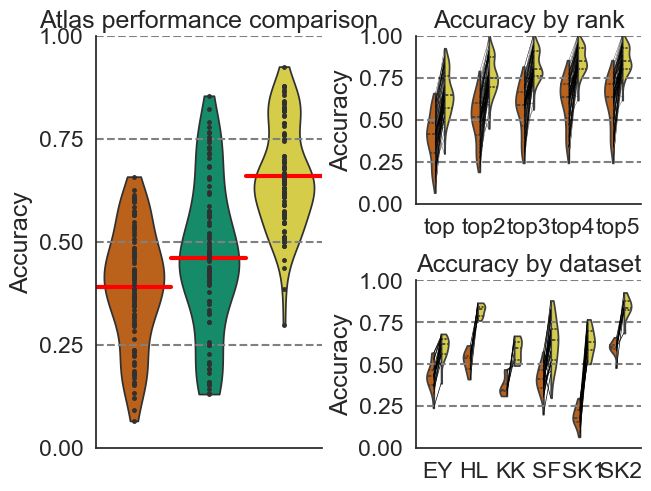

In [28]:
labels = ['EY', 'HL', 'KK', 'SF', 'SK1', 'SK2']
datasets = [EY_dataset,HL_dataset, KK_dataset, SF_dataset, SK1_dataset, SK2_dataset]

accs_base, accs_match, accs_full_nomatch, accs_fullmatch = gen_plots_acc(datasets, labels, skipfiles, accs_NP_unmatch, accs_NP, accs_full_unmatch, accs_full)